In [1]:
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import struct

def leer_gadget2_por_tipo(file_path):
    with open(file_path, "rb") as f:
        # Leer header
        f.seek(0)
        _ = struct.unpack("I", f.read(4))[0]
        header_bytes = f.read(256)
        _ = struct.unpack("I", f.read(4))[0]

        # npart = número de partículas por tipo
        npart = struct.unpack("6I", header_bytes[0:24])
        masses_from_header = struct.unpack("6d", header_bytes[24:72])  # masas por tipo si son iguales
        total_particles = sum(npart)
        tipos_presentes = [i for i, n in enumerate(npart) if n > 0]

        # print(f"Tipos presentes: {tipos_presentes}")
        # print(f"Total de partículas: {total_particles}")

        # Leer POS
        _ = struct.unpack("I", f.read(4))[0]
        positions = np.fromfile(f, dtype=np.float32, count=total_particles * 3).reshape((total_particles, 3))
        _ = struct.unpack("I", f.read(4))[0]

        # Leer VEL
        _ = struct.unpack("I", f.read(4))[0]
        velocities = np.fromfile(f, dtype=np.float32, count=total_particles * 3).reshape((total_particles, 3))
        _ = struct.unpack("I", f.read(4))[0]

        # Leer IDs
        _ = struct.unpack("I", f.read(4))[0]
        ids = np.fromfile(f, dtype=np.uint32, count=total_particles)
        _ = struct.unpack("I", f.read(4))[0]

        # Leer masas si hay (algunas simulaciones lo hacen)
        masses = None
        try:
            _ = struct.unpack("I", f.read(4))[0]
            masses = np.fromfile(f, dtype=np.float32, count=total_particles)
            _ = struct.unpack("I", f.read(4))[0]
        except:
            masses = None

    # Separar los datos por tipo de partícula
    dfs_por_tipo = {}
    offset = 0
    for tipo, n_part in enumerate(npart):
        if n_part == 0:
            continue

        # Obtener fragmentos por tipo
        pos = positions[offset:offset+n_part]
        vel = velocities[offset:offset+n_part]
        id_ = ids[offset:offset+n_part]
        if masses is not None:
            m = masses[offset:offset+n_part]
        elif masses_from_header[tipo] != 0:
            m = np.full(n_part, masses_from_header[tipo])
        else:
            m = None

        data = {
            "id": id_,
            "x": pos[:, 0],
            "y": pos[:, 1],
            "z": pos[:, 2],
            "v_x": vel[:, 0],
            "v_y": vel[:, 1],
            "v_z": vel[:, 2],
        }
        if m is not None:
            data["Mass"] = m

        df = pd.DataFrame(data)
        dfs_por_tipo[tipo] = df
        offset += n_part

    return dfs_por_tipo

# Uso
archivo = r"Archivos\AM2229-735_host_RL_050"
dfs = leer_gadget2_por_tipo(archivo)

# Mostrar resultados
# for tipo, df in dfs.items():
#     print(f"\nTipo {tipo} — Partículas: {len(df)}")

dfs[1], dfs[2], dfs[3]


In [3]:
def centrar_galaxia(base_de_datos):
    
    masa_total_galaxia = base_de_datos.masa.sum()

    x_cm = base_de_datos.masa @ base_de_datos.x / masa_total_galaxia
    y_cm = base_de_datos.masa @ base_de_datos.y / masa_total_galaxia
    z_cm = base_de_datos.masa @ base_de_datos.z / masa_total_galaxia

    base_de_datos['x0'] = base_de_datos.x - x_cm
    base_de_datos['y0'] = base_de_datos.y - y_cm
    base_de_datos['z0'] = base_de_datos.z - z_cm

centrar_galaxia(galaxia_df)

galaxia_df

,id,x,y,z,v_x,v_y,v_z,masa,x0,y0,z0
0,429542,-6139.246094,-65.043045,-4120.191406,-211.133438,-2.388370,-141.643646,0.000030,-6142.972656,-63.242546,-4119.605957
1,2031584,-5968.082520,-808.355225,-4296.529785,-205.248184,-27.948269,-147.707611,0.000030,-5971.809082,-806.554749,-4295.944336
2,855092,-6168.680176,-1607.304321,-3851.701904,-212.151428,-55.422649,-132.414932,0.000030,-6172.406738,-1605.503784,-3851.116455
3,1383630,-5093.544922,-2260.614502,-4018.954346,-175.120163,-77.861580,-138.118774,0.000030,-5097.271484,-2258.813965,-4018.368896
4,865115,-4793.813965,-2562.677246,-3903.351074,-164.795074,-88.233559,-134.127151,0.000030,-4797.540527,-2560.876709,-3902.765625
...,...,...,...,...,...,...,...,...,...,...,...
4334756,4176709,80.001984,31.998182,279.918488,20.145805,43.748489,8.327011,0.000004,76.275436,33.798679,280.504028
4334757,4137086,53.549637,34.668991,276.359558,80.362534,-12.354066,20.103807,0.000004,49.823093,36.469490,276.945099
4334758,4174688,13.888486,60.761311,265.012543,18.216602,17.566277,-44.761848,0.000004,10.161942,62.561810,265.598083
4334759,4285619,57.072998,118.474464,271.629486,-40.505226,-79.648994,8.942924,0.000004,53.346455,120.274963,272.215027


In [4]:
def rotar_galaxia(base_de_datos):
    lx = (base_de_datos.x @ base_de_datos.v_z) - (base_de_datos.z @ base_de_datos.v_y)
    ly = (base_de_datos.z @ base_de_datos.v_x) - (base_de_datos.x @ base_de_datos.v_z)
    lz = (base_de_datos.x @ base_de_datos.v_y) - (base_de_datos.y @ base_de_datos.v_x)

    magnitud_l = np.linalg.norm([lx, ly, lz])

    angulo_z = - np.atan(ly / lx)
    angulo_y = np.acos(lz / magnitud_l)
     
    cos_z = np.cos(angulo_z)
    sin_z = np.sin(angulo_z)
    cos_y = np.cos(angulo_y)
    sin_y = np.sin(angulo_y)

    base_de_datos['x_f'] = (
    base_de_datos.x0 * (cos_z * cos_y) + 
    base_de_datos.y0 * (- sin_z) +
    base_de_datos.z0 * (cos_z * sin_y)
    )
    
    base_de_datos['y_f'] = (
        base_de_datos.x0 * (sin_z * cos_y) + 
        base_de_datos.y0 * (cos_z) +
        base_de_datos.z0 * (sin_z * sin_y)
        )

    base_de_datos['z_f'] = (
        base_de_datos.x0 * (- sin_y) + 
        base_de_datos.z0 * (cos_y)
        )

rotar_galaxia(galaxia_df)
galaxia_df

,id,x,y,z,v_x,v_y,v_z,masa,x0,y0,z0,x_f,y_f,z_f
0,429542,-6139.246094,-65.043045,-4120.191406,-211.133438,-2.388370,-141.643646,0.000030,-6142.972656,-63.242546,-4119.605957,-4980.784668,3614.372314,-4103.579102
1,2031584,-5968.082520,-808.355225,-4296.529785,-205.248184,-27.948269,-147.707611,0.000030,-5971.809082,-806.554749,-4295.944336,-5286.383789,2915.614990,-4280.362793
2,855092,-6168.680176,-1607.304321,-3851.701904,-212.151428,-55.422649,-132.414932,0.000030,-6172.406738,-1605.503784,-3851.116455,-5922.446289,2392.623535,-3835.013672
3,1383630,-5093.544922,-2260.614502,-4018.954346,-175.120163,-77.861580,-138.118774,0.000030,-5097.271484,-2258.813965,-4018.368896,-5448.283203,1227.739746,-4005.068115
4,865115,-4793.813965,-2562.677246,-3903.351074,-164.795074,-88.233559,-134.127151,0.000030,-4797.540527,-2560.876709,-3902.765625,-5387.185059,806.399414,-3890.246582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334756,4176709,80.001984,31.998182,279.918488,20.145805,43.748489,8.327011,0.000004,76.275436,33.798679,280.504028,81.988129,-18.715738,280.304260
4334757,4137086,53.549637,34.668991,276.359558,80.362534,-12.354066,20.103807,0.000004,49.823093,36.469490,276.945099,62.322941,-0.809699,276.814270
4334758,4174688,13.888486,60.761311,265.012543,18.216602,17.566277,-44.761848,0.000004,10.161942,62.561810,265.598083,45.981140,43.789604,265.570679
4334759,4285619,57.072998,118.474464,271.629486,-40.505226,-79.648994,8.942924,0.000004,53.346455,120.274963,272.215027,115.058289,64.418114,272.075043


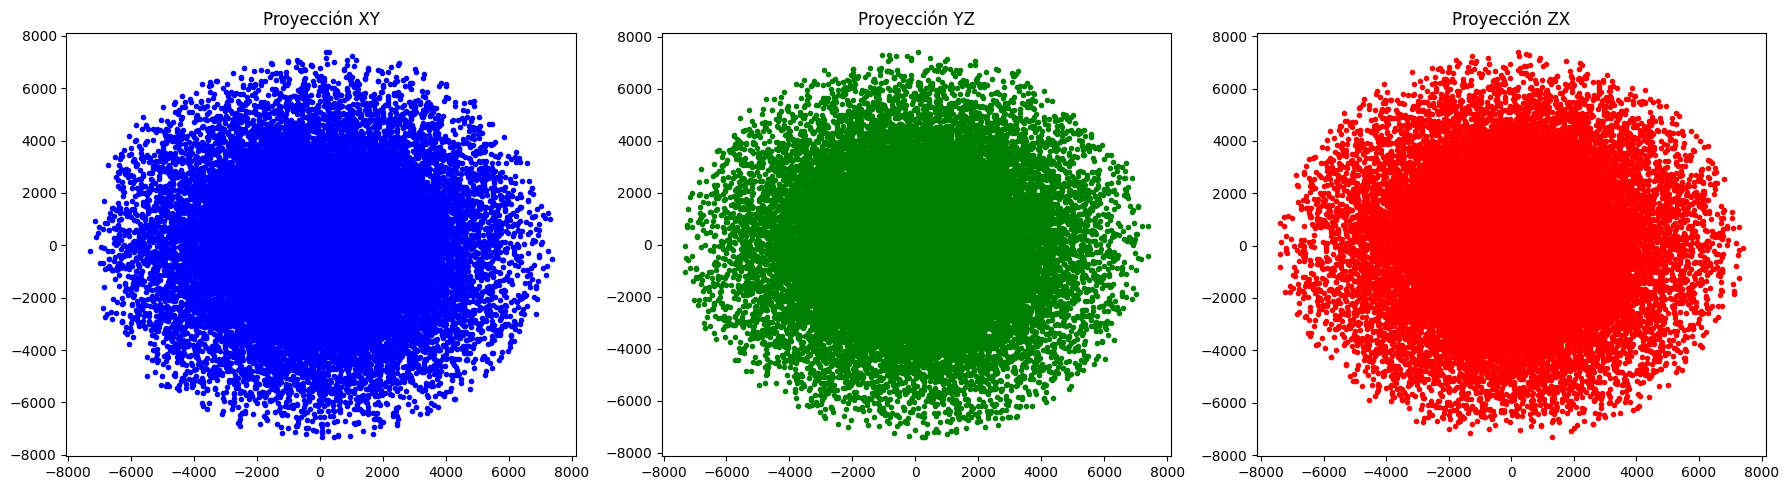

In [12]:
import matplotlib.pyplot as plt

# Creamos una figura con 3 subplots en una sola fila (1 fila, 3 columnas)
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Ancho x alto en pulgadas

# Primer gráfico: masa vs radio
axs[0].scatter(galaxia_df.x_f, galaxia_df.y_f, color='blue', marker= '.')
axs[0].set_title('Proyección XY')

# Segundo gráfico
axs[1].scatter(galaxia_df.y_f, galaxia_df.z_f, color='green', marker= '.')
axs[1].set_title('Proyección YZ')

# Tercer gráfico
axs[2].scatter(galaxia_df.z_f, galaxia_df.x_f, color='red', marker= '.')
axs[2].set_title('Proyección ZX')

# Ajustar los espacios entre los subplots para evitar superposición
plt.tight_layout()
plt.show()


,id,x,y,z,v_x,v_y,v_z,Mass
0,429542,-6139.246094,-65.043045,-4120.191406,-211.133438,-2.388370,-141.643646,0.00003
1,2031584,-5968.082520,-808.355225,-4296.529785,-205.248184,-27.948269,-147.707611,0.00003
2,855092,-6168.680176,-1607.304321,-3851.701904,-212.151428,-55.422649,-132.414932,0.00003
3,1383630,-5093.544922,-2260.614502,-4018.954346,-175.120163,-77.861580,-138.118774,0.00003
4,865115,-4793.813965,-2562.677246,-3903.351074,-164.795074,-88.233559,-134.127151,0.00003
...,...,...,...,...,...,...,...,...
2339756,343718,120.103195,145.659180,312.503510,-18.350237,-2.443171,10.712067,0.00003
2339757,471962,120.490921,142.101440,320.486481,52.796936,8.825765,-35.197010,0.00003
2339758,313017,112.549156,129.538635,329.528168,-66.492874,62.996265,36.272236,0.00003
2339759,398341,101.843452,129.559280,321.319794,-3.732927,15.605130,5.751881,0.00003
